# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import glob

# Load data

In [2]:
def load_mnist():
    # Loads the MNIST dataset from png images
 
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

In [3]:
def plot_digits(X,Y,nr):
    fig, axes = plt.subplots(1, nr, figsize=(12,4))
    
    # Shuffle the data and labels in the same order
    shuffle_indices = np.arange(X.shape[0])
    np.random.shuffle(shuffle_indices)

    X = X[shuffle_indices]
    Y = Y[shuffle_indices]
    
    # Plots
    for i, ax in enumerate(axes):
        img = X[i].reshape(28, 28)
        label = np.argmax(Y[i])
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.show()
    

In [4]:
X_train, Y_train, X_test, Y_test = load_mnist()

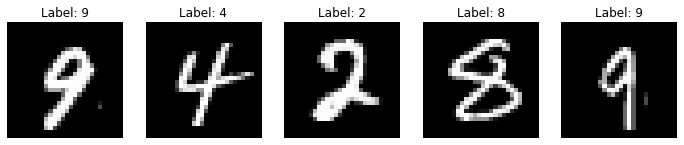

In [5]:
plot_digits(X_train, Y_train, 5)

In [6]:
X_train.shape

(60000, 784)

In [7]:
X_train[0].shape

(784,)

# Neural Net Functions

In [590]:
def initialize_parameters(layers, func):
    """
    W and b are standard python lists.
    W[i] is the weight matrix for layer i.
    b[i is the bias/offset vector for layer i.
    """
    
    model_states = []  # List of dictionaries, one dictionary for each layer
    
    # Initialize weights and biases
    for i in range(len(layers)-1):
        layer_state = {}
        
        cols = layers[i]
        rows = layers[i+1]
        
        W_i = np.random.normal(loc=0, scale=0.01, size=(rows, cols))
        b_i = np.zeros((rows,1))
        
        layer_state["W"] = W_i
        layer_state["b"] = b_i
        
        layer_state["func"] = func
        
        model_states.append(layer_state)
        
    return model_states

### Forward

In [591]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [592]:
def relu(x):
    return np.maximum(0,x)

In [593]:
def linear_forward(w_i, x, b_i):
    """
    w_i is a (D1,D2) weight matrix for one layer
    x is (D2,1) vector
    b_i is a (D1,1) vector
    
    z is a (D1,1) vector

    """
    return np.matmul(w_i,x)+b_i

In [594]:
def activation_forward(z,act_func):
    """
    z is a vector, representing a layer
    func specifies which activation function
    """
    
    if act_func=="relu":
        return relu(z)
    elif act_func == "sigmoid":
        return sigmoid(z)
    

In [726]:
def model_forward(model_states, x):
    """
    model_states is list of dictionaries,
    where each dictionary containts information about each layer
    
    x is the input (781,1)
    
    act_func specifies which activation function to use
    """
    nr_layers = len(model_states)
    
    for i in range(nr_layers):
        layer_state = model_states[i]
        
        # Store input
        layer_state["x"] = x
        
        # Get weights and biases
        W = layer_state["W"]
        b = layer_state["b"]
        
        # Linear forward
        z = linear_forward(W,x,b)
        layer_state["linear_output"] = z
        #print("z=",z.shape)
        
        # Activation
        a = activation_forward(z,layer_state["func"])
        layer_state["activation_output"] = a
        #print("a=",a.shape)
        
        # Step
        x=a
    
    return a

In [727]:
def softmax(z):
    """
    z is the models output represented by a (10,1) vector
    """
    z_exp = np.exp(z)
    return z_exp/np.sum(z_exp)

### Loss

In [728]:
def compute_loss(z,y):
    """
    Loss according to cross entropy, eq.2
    
    z is the model output as vector with size (10,1)
    y is the one hot encoding true label with size (10,1)
    
    Subtract maximum to increase stability. Change in loss (+-4.440892098500626e-16)
    """

    z = z - np.amax(z)
    return np.log(np.sum(np.exp(z))) - np.dot(z,y)
    

In [772]:
def compute_cost(Z,Y):
    # Nr of datapoints
    n = len(Y) 
    
    # Total cost
    cost = 0
    for i in range(n):
        cost += compute_loss(Z[i],Y[i])
        
    # Average cost
    avg_cost = cost/n
        
    return avg_cost
        

### Backward

In [773]:
def linear_backward(curr_layer):
    """
    dW_i = dz_i x.T
    db_i = dz_i
    """
    
    # Read layer_state
    dz = curr_layer["dz"]
    x = curr_layer["x"]# input to layer
    
    # Reshape
    
    dz = dz.reshape((len(dz),1))
    xt = x.reshape((1,len(x)))
    
    # Backprop
    dW = np.dot(dz,xt)
    db = dz
    
    # Save results
    curr_layer["dW"] = dW
    curr_layer["db"] = db.reshape((len(db),1))

In [774]:
def sigmoid_backward(z):
    """
    x is a number that is the input to the sigmoid
    """
    return sigmoid(z) * (1-sigmoid(z))

In [775]:
def relu_backward(z):
    """
    x is a number that is the input to the relu
    """
    if z>0:
        derivative = 1
    else:
        derivative = 0
    return derivative

In [776]:
def activation_backward(curr_layer, prev_layer):
    """
    eq. 6.27b and 6.27a
    dz_{i} = W_{i+2}^T dz_{i+2} .* act_func'(z_i)
    """
    
    W_ii = prev_layer["W"]
    dz_ii = prev_layer["dz"]
    dz_ii.reshape((len(dz_ii),1))
    
    
    func = curr_layer["func"]
    z = curr_layer["linear_output"]

    
    if func == "relu":
        curr_layer["dz"] = np.multiply(np.dot(W_ii.T,dz_ii),relu_backward(z))
    else:
        curr_layer["dz"] = np.multiply(np.dot(W_ii.T,dz_ii),sigmoid_backward(z))

In [777]:
def model_backward(model_states, y):
    nr_layers = len(model_states)
    
    last_layer = model_states[nr_layers-1]
    
    last_layer["dz"] = softmax(last_layer["linear_output"])-y
    linear_backward(last_layer)
    
    for i in reversed(range(1,nr_layers)):
        curr_layer = model_states[i-1]
        prev_layer = model_states[i]
        
        activation_backward(curr_layer,prev_layer)
        linear_backward(curr_layer)

    return
        

In [778]:
def update_parameters(model_states, learning_rate):
    """
    model_states is a list containing one dictionary per layer.
    Each dictionary store information about that layer
    """
    nr_layers = len(model_states)
    
    for i in range(nr_layers):
        layer_state = model_states[i]
        
        layer_state["W"] = layer_state["W"] - learning_rate*layer_state["dW"]
        layer_state["b"] = layer_state["b"] - learning_rate*layer_state["db"]
    return

### General

In [781]:
def predict(model_states, X, Y):
    model_output = np.zeros((len(Y),10))
    
    correct = 0
    for i in range(len(Y)):
        model_output[i] = model_forward(model_states, X[i].reshape((784,1))).reshape(1,10)
        true_output = np.argmax(Y[i].reshape((10,1)))
        
        if np.argmax(model_output[i]) == true_output:
            correct += 1
    
    acc = correct/len(Y)
        
    return model_output, acc

In [782]:
def random_mini_batches(X,Y,batch_size):
    mini_batches = []
    nr_datapoints = len(X)
    nr_batches = nr_datapoints//batch_size
    
    # Shuffle X and Y
    shuffle_indices = np.random.permutation(nr_datapoints)
    X = X[shuffle_indices]
    Y = Y[shuffle_indices]
    
    # Organize into mini-batches
    for i in range(nr_batches):
        start = i*batch_size
        end = (i+1)*batch_size
        
        x_mini = X[start:end]
        y_mini = Y[start:end]
        mini_batches.append((x_mini, y_mini))
    
    # Remainder
    if nr_datapoints % batch_size != 0:
        start = nr_batches*batch_size
        
        x_mini = X[start:]
        y_mini = Y[start:]
        mini_batches.append((x_mini, y_mini))
    
    

    return mini_batches

### Training

In [793]:
def train_model(X_train, Y_train, layers, act_func, iterations, learning_rate, batch_size, X_test, Y_test):
    
    # Initialize
    model_states = initialize_parameters(layers, act_func)
    
    # Print net setup
    print("Neural network architecture:")
    for i in range(len(model_states)):
        layer_state = model_states[i]
        print("   Layer ",i)
        print("      dim(W)      =",layer_state["W"].shape)
        print("      dim(b)      =",layer_state["b"].shape)
        print()
        
    print("_____________________________________")
        
    # Train
    for epoch in range(iterations):
        print("Epoch ",epoch)
        mini_batches = random_mini_batches(X_train, Y_train, batch_size)
        
        # Performance
        Z, acc = predict(model_states,X_test,Y_test)
        cost = compute_cost(Z,Y_test)
        print("  Cost = ", cost)
        print("  Accuracy = ", acc)
        
        for batch in mini_batches:  
            X = batch[0]
            Y = batch[1]
            for i in range(batch_size): 
                # Each x,y pair is a datapoint (image with label)
                x = X[i]
                y = Y[i]
                
                #Reshape
                x = x.reshape((784,1))
                y = y.reshape((10,1))
                
                # Forward pass in network
                a = model_forward(model_states,x)
                #print("forward output:",a.shape)

                # Backpropogation
                model_backward(model_states,y)

                # Update parameters
                update_parameters(model_states, learning_rate)
        
    
    return model_states

# Train model

In [795]:
layers = [784,16,10]
model_states = train_model(X_train, Y_train, layers, 'sigmoid', 10, 0.001, 500, X_test, Y_test)
    

Neural network architecture:
   Layer  0
      dim(W)      = (16, 784)
      dim(b)      = (16, 1)

   Layer  1
      dim(W)      = (10, 16)
      dim(b)      = (10, 1)

_____________________________________
Epoch  0
  Cost =  2.3025463177150938
  Accuracy =  0.098
Epoch  1
  Cost =  1.9944634729824826
  Accuracy =  0.6796
Epoch  2
  Cost =  1.891692513688002
  Accuracy =  0.8428
Epoch  3
  Cost =  1.8702303363257786
  Accuracy =  0.8852
Epoch  4
  Cost =  1.8618621249428489
  Accuracy =  0.899
Epoch  5
  Cost =  1.858236524312945
  Accuracy =  0.9079
Epoch  6
  Cost =  1.8565127131550172
  Accuracy =  0.9146
Epoch  7
  Cost =  1.8545042129238973
  Accuracy =  0.9179
Epoch  8
  Cost =  1.8532275271250025
  Accuracy =  0.9208
Epoch  9
  Cost =  1.8526637051394461
  Accuracy =  0.9225


# Test final model

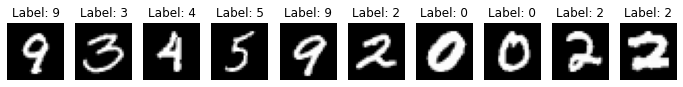

Accurcy on test data =  0.9258


In [821]:
Z, acc = predict(model_states,X_test,Y_test)
plot_digits(X_test, Z, 10)
print("Accurcy on test data = ", acc)